## <center>Neruális hálók - függvény illesztése - univerzális apporximációs tétel</center>

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

def draw_network(x0, weight_scale=3.0):
    """
    Kirajzolja a 4-neuronos MLP-t egy adott x0 bemenetnél.
    - weight_scale: a súly vastagságának skálázása
    """
    global W1, b1, W2, b2

    # Forward egy ponttal
    y_pred, z1, h1 = forward(np.array([x0]))
    z1 = z1[0]   # (4,)
    h1 = h1[0]   # (4,)
    y_pred = y_pred[0]

    # --- Elrendezés: koordináták ---
    # x-koordináták: input (0), hidden (1), output (2)
    x_input = 0.0
    x_hidden = 1.0
    x_output = 2.0

    # y-koordináták: szép elosztás
    y_input = 0.0
    y_hidden = np.linspace(1.5, -1.5, len(h1))
    y_output = 0.0

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-2.0, 2.0)
    ax.axis("off")

    # --- Helper: szín az aktiváció alapján ---
    def node_color(value):
        # ha nagyon kicsi, szürke; különben zöld
        if abs(value) < 1e-6:
            return "darkgray"
        else:
            return "limegreen"

    # --- 1) Input neuron ---
    inp = Circle((x_input, y_input), 0.1, edgecolor="white",
                 facecolor=node_color(x0), linewidth=1.5)
    ax.add_patch(inp)
    ax.text(x_input, y_input-0.25, f"x={x0:.2f}",
            ha="center", va="top", color="white", fontsize=9)

    # --- 2) Hidden neuronok ---
    hidden_nodes = []
    for i, y in enumerate(y_hidden):
        c = Circle((x_hidden, y), 0.1, edgecolor="white",
                   facecolor=node_color(h1[i]), linewidth=1.5)
        ax.add_patch(c)
        hidden_nodes.append((x_hidden, y))
        ax.text(x_hidden, y+0.2, f"h{i+1}\n{h1[i]:.2f}",
                ha="center", va="bottom", color="white", fontsize=8)

    # --- 3) Output neuron ---
    out = Circle((x_output, y_output), 0.12, edgecolor="white",
                 facecolor=node_color(y_pred), linewidth=2)
    ax.add_patch(out)
    ax.text(x_output, y_output-0.25, f"y={y_pred:.2f}",
            ha="center", va="top", color="white", fontsize=9)

    # --- 4) Élek: input -> hidden (W1) ---
    for i, (xh, yh) in enumerate(hidden_nodes):
        w = W1[i]          # mert 1D input → W1: (4,)
        color = "blue" if w >= 0 else "red"
        width = 0.5 + weight_scale * abs(w)

        line = Line2D([x_input, xh], [y_input, yh],
                      linewidth=width, color=color, alpha=0.5)
        ax.add_line(line)

        # kis súly-felirat középre
        xm = (x_input + xh) / 2
        ym = (y_input + yh) / 2
        ax.text(xm, ym, f"{w:.2f}", color=color, fontsize=7,
                ha="center", va="center")

    # --- 5) Élek: hidden -> output (W2) ---
    for i, (xh, yh) in enumerate(hidden_nodes):
        w = W2[i]
        color = "blue" if w >= 0 else "red"
        width = 0.5 + weight_scale * abs(w)

        line = Line2D([xh, x_output], [yh, y_output],
                      linewidth=width, color=color, alpha=0.5)
        ax.add_line(line)

        xm = (xh + x_output) / 2
        ym = (yh + y_output) / 2
        ax.text(xm, ym+0.05, f"{w:.2f}", color=color, fontsize=7,
                ha="center", va="bottom")

    # --- 6) Bias-ok kiírása ---
    for i, (xh, yh) in enumerate(hidden_nodes):
        ax.text(xh-0.05, yh-0.35, f"b1[{i}]={b1[i]:.2f}",
                ha="right", va="top", color="yellow", fontsize=7)

    ax.text(x_output+0.1, y_output+0.3, f"b2={b2:.2f}",
            ha="left", va="bottom", color="yellow", fontsize=8)

    # --- Cím ---
    ax.set_title(f"4-neuronos MLP hálózódiagram\naktiváció: {activation_name},  x={x0:.2f},  y={y_pred:.2f}",
                 color="white")
    fig.patch.set_facecolor("black")
    ax.set_facecolor("black")
    plt.tight_layout()
    plt.show()



















import numpy as np
import matplotlib.pyplot as plt

# ==== 1) Aktivációk ====

def activation(z, name):
    if name == "none":
        return z
    elif name == "relu":
        return np.maximum(0, z)
    elif name == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif name == "tanh":
        return np.tanh(z)
    else:
        raise ValueError(f"Ismeretlen aktiváció: {name}")

def activation_deriv(z, name):
    if name == "none":
        return np.ones_like(z)
    elif name == "relu":
        return (z > 0).astype(float)
    elif name == "sigmoid":
        s = 1 / (1 + np.exp(-z))
        return s * (1 - s)
    elif name == "tanh":
        t = np.tanh(z)
        return 1 - t**2
    else:
        raise ValueError(f"Ismeretlen aktiváció: {name}")


# ==== 2) Modell beállítások ====

activation_name = "relu"   # próbáld: "none", "relu", "sigmoid", "tanh"

# Rejtett réteg: 4 neuron
hidden_size = 16

# Bemeneti tartomány és célfüggvény
def target_function(x):
    return np.sin(x)

x_train = np.linspace(-np.pi, np.pi, 400)   # (N,)
y_train = target_function(x_train)          # (N,)
N = x_train.shape[0]

# ==== 3) Paraméterek (globálisak, hogy kézzel tudjuk léptetni) ====

rng = np.random.default_rng(0)

# W1: (4,), b1: (4,)
W1 = rng.normal(0, 0.5, size=(hidden_size,))
b1 = rng.normal(0, 0.5, size=(hidden_size,))

W1 = np.array([-2.0, -1.0, 1.0, 2.0 ])
b1 = np.array([ 1.0, 0, -1.0, 0.0 ])

#W2 = rng.normal(0, 0.5, size=(hidden_size,))

W2 = np.array([ -1.0, 1.0, 0.0, -1.0 ])
b2 = 1.0



# ==== 4) Forward pass ====

def forward(x):
    """
    x: alak (N,)
    visszaadja: y_pred (N,), plusz köztes értékeket a backprop-hoz
    """
    global W1, b1, W2, b2

    # Rejtett réteg
    z1 = x[:, None] * W1[None, :] + b1[None, :]      # (N,4)
    h1 = activation(z1, activation_name)             # (N,4)

    # Kimenet
    y_pred = h1 @ W2 + b2                            # (N,)

    return y_pred, z1, h1


# ==== 5) Loss (MSE) ====

def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)


# ==== 6) Egy darab backprop + súlyfrissítés ====

def train_step(lr=0.01):
    """
    Egyetlen gradient descent lépés.
    Visszaadja az aktuális losst.
    """
    global W1, b1, W2, b2

    # Forward
    y_pred, z1, h1 = forward(x_train)

    # Loss
    loss = mse_loss(y_pred, y_train)

    # dL/dy_pred
    dL_dy = 2 * (y_pred - y_train) / N              # (N,)

    # Output réteg grádiensei
    # y_pred = h1 @ W2 + b2
    # dL/dW2 = h1^T @ dL/dy
    dL_dW2 = h1.T @ dL_dy                           # (4,)
    dL_db2 = np.sum(dL_dy)                          # skalar

    # Rejtett réteg grádiensei
    # dL/dh1 = dL/dy[:,None] * W2[None,:]
    dL_dh1 = dL_dy[:, None] * W2[None, :]           # (N,4)

    # dL/dz1 = dL/dh1 * sigma'(z1)
    dL_dz1 = dL_dh1 * activation_deriv(z1, activation_name)  # (N,4)

    # z1 = x[:,None] * W1[None,:] + b1[None,:]
    # dL/dW1 = x^T @ dL_dz1
    dL_dW1 = x_train[:, None].T @ dL_dz1            # (1,4) -> (4,)
    dL_dW1 = dL_dW1.reshape(-1)

    # dL/db1 = sum_n dL_dz1[n,:]
    dL_db1 = np.sum(dL_dz1, axis=0)                 # (4,)

    # Gradient descent lépés
    W2 -= lr * dL_dW2
    b2 -= lr * dL_db2
    W1 -= lr * dL_dW1
    b1 -= lr * dL_db1

    return loss

def plot_hidden_activations():
    _, z1, h1 = forward(x_train)

    plt.figure(figsize=(10, 6))
    for i in range(h1.shape[1]):
        plt.plot(x_train, h1[:, i], label=f"Neuron {i+1}")

    plt.title(f"Rejtett neuronok aktivációi (ReLU)")
    plt.xlabel("x")
    plt.ylabel("h_i(x)")
    plt.grid(True)
    plt.legend()
    plt.show()


def explain_contributions(x0):
    """Kiírja, hogy a 4 neuron hogyan járul hozzá f(x0)-hoz."""
    global W1, b1, W2, b2

    # forward pass egyetlen ponttal
    y_pred, z1, h1 = forward(np.array([x0]))

    print(f"\n--- Hozzájárulások x = {x0} esetén ---")
    print(f"Rejtett kimenetek h1(x): {h1[0]}")
    print(f"W2 súlyok: {W2}")
    print()

    contributions = W2 * h1[0]     # elemről elemre szorzás
    for i, c in enumerate(contributions):
        print(f"Neuron {i+1}:  W2[{i}] * h1[{i}]  =  {W2[i]:.4f} * {h1[0,i]:.4f}  =  {c:.4f}")

    total = np.sum(contributions) + b2
    print(f"\nb2 hozzáadva: {b2:.4f}")
    print(f"Összeg (f(x)): {total:.4f}   | forward(): {y_pred[0]:.4f}")

    return total



# ==== 7) Plot helper: aktuális közelítés kirajzolása ====

def plot_current(title_suffix=""):
    y_pred, _, _ = forward(x_train)

    plt.figure(figsize=(8, 5))
    plt.plot(x_train, y_train, label="sin(x)", linewidth=2)
    plt.plot(x_train, y_pred, "--", label="MLP approx", linewidth=2)
    plt.title(f"Aktuális közelítés (aktiváció: {activation_name}) {title_suffix}")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



Először  kiplotolhatjuk, hogy a kezdeti paraméterek mellett hogyan néz ki a függvényünk.

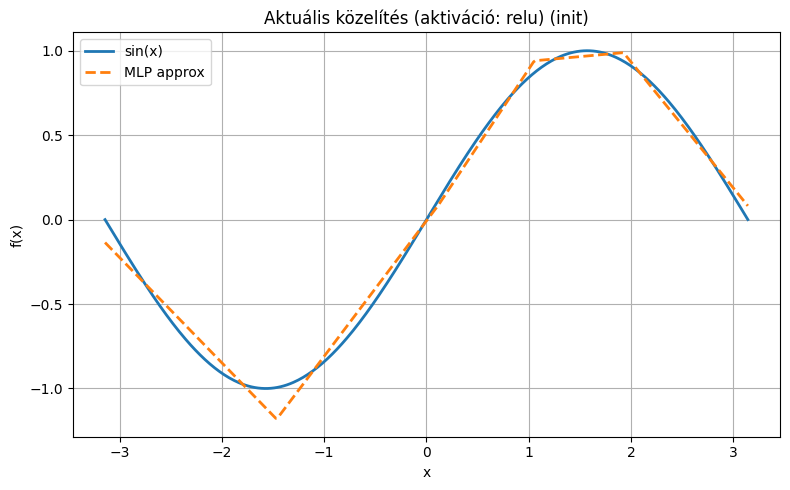

In [63]:
plot_current("(init)")

Az iterációk számát változtatva és a cellát újra és újra futtatva látjuk, ahogy a neurális háló rátanul a sin(x) függvényre

Lépés 1001, loss = 0.003148


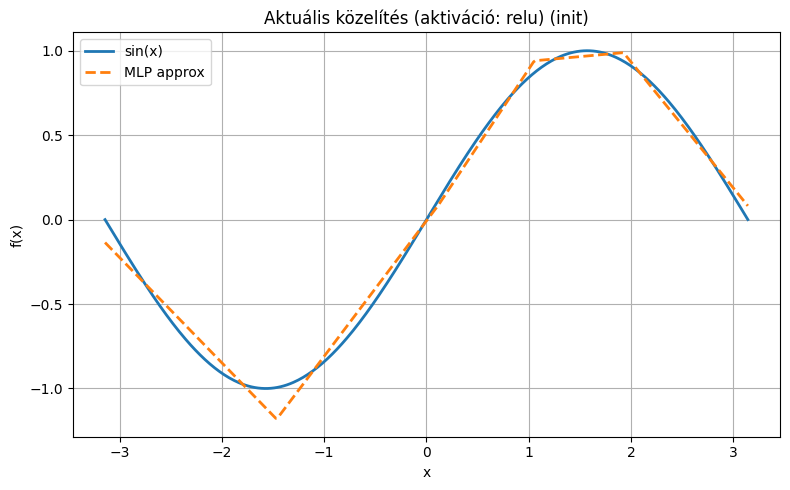


--- Hozzájárulások x = 1.0 esetén ---
Rejtett kimenetek h1(x): [0.91961597 0.         0.         1.52309908]
W2 súlyok: [-0.80670142  1.58950009 -0.77255538  0.06429042]

Neuron 1:  W2[0] * h1[0]  =  -0.8067 * 0.9196  =  -0.7419
Neuron 2:  W2[1] * h1[1]  =  1.5895 * 0.0000  =  0.0000
Neuron 3:  W2[2] * h1[2]  =  -0.7726 * 0.0000  =  -0.0000
Neuron 4:  W2[3] * h1[3]  =  0.0643 * 1.5231  =  0.0979

b2 hozzáadva: 1.5350
Összeg (f(x)): 0.8911   | forward(): 0.8911
toréspontok: [ 1.92562    -1.46421754  1.05409879  0.1107457 ]


In [62]:
for i in range(1000):
    loss = train_step(lr=0.01)
print(f"Lépés {i+2}, loss = {loss:.6f}")
plot_current("(init)")
x0 = 1.0
explain_contributions(x0)
print("toréspontok:", -b1 / W1)

### Szemléltető példák tanulásra, illetve az illesztés pontosságára az illesztése intervallumon kívül

Epoch    0 | Loss = 2.232973
Epoch  200 | Loss = 0.101646
Epoch  400 | Loss = 0.067026
Epoch  600 | Loss = 0.042166
Epoch  800 | Loss = 0.029276
Epoch 1000 | Loss = 0.023939
Epoch 1200 | Loss = 0.021395
Epoch 1400 | Loss = 0.019758
Epoch 1600 | Loss = 0.018462
Epoch 1800 | Loss = 0.017345
Epoch 2000 | Loss = 0.016356
Epoch 2200 | Loss = 0.015473
Epoch 2400 | Loss = 0.014680
Epoch 2600 | Loss = 0.013966
Epoch 2800 | Loss = 0.013320
Epoch 3000 | Loss = 0.012735
Epoch 3200 | Loss = 0.012203
Epoch 3400 | Loss = 0.011717
Epoch 3600 | Loss = 0.011273
Epoch 3800 | Loss = 0.010865
Epoch 4000 | Loss = 0.010489
Epoch 4200 | Loss = 0.010142
Epoch 4400 | Loss = 0.009819
Epoch 4600 | Loss = 0.009519
Epoch 4800 | Loss = 0.009239
Epoch 5000 | Loss = 0.008978
Epoch 5200 | Loss = 0.008732
Epoch 5400 | Loss = 0.008501
Epoch 5600 | Loss = 0.008283
Epoch 5800 | Loss = 0.008077
Epoch 6000 | Loss = 0.007882
Epoch 6200 | Loss = 0.007698
Epoch 6400 | Loss = 0.007522
Epoch 6600 | Loss = 0.007355
Epoch 6800 | L

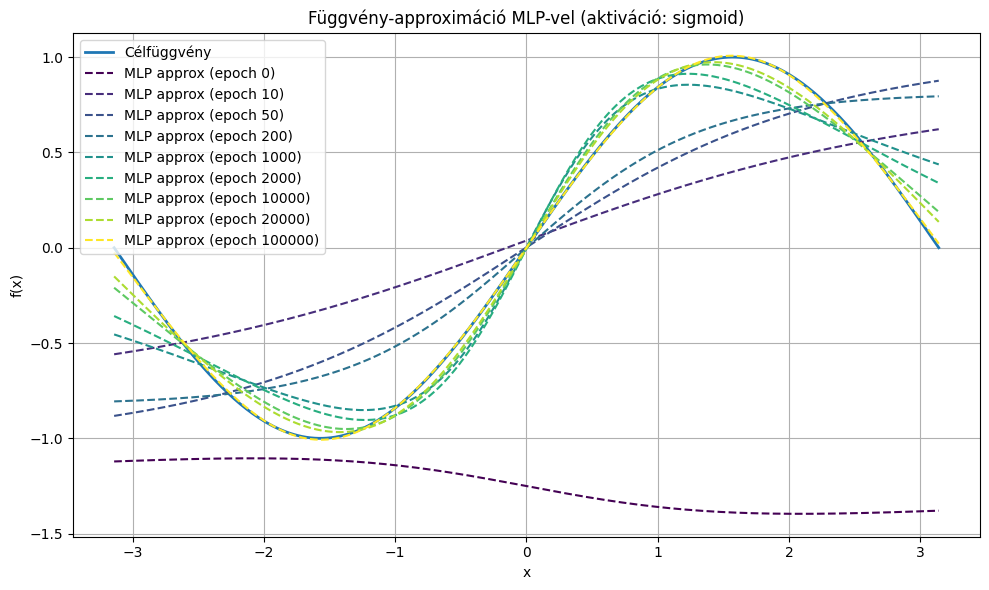

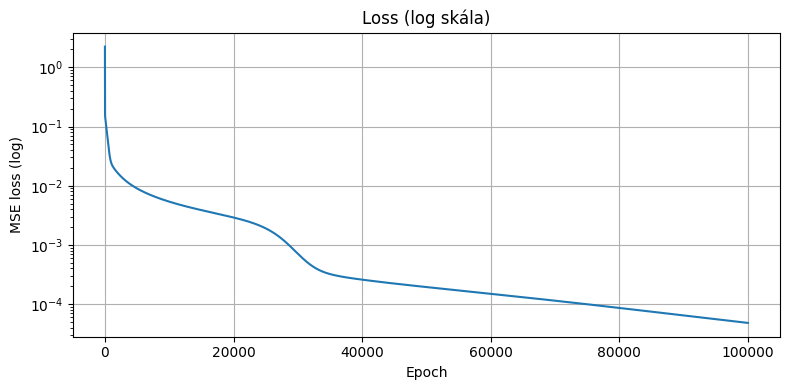

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Beállítások =====

# Választható: "none", "relu", "sigmoid", "tanh"
activation_name = "sigmoid"   # próbáld ki: "none" is!

hidden_size = 8            # rejtett neuronok száma
learning_rate = 0.1
epochs = 100001
plot_snapshots = [0, 10, 50, 200, 1000, 2000,10000,20000,100000]  # mely epochokon rajzoljunk közelítést

# Approximálandó függvény: tetszőlegesen átírható
def target_function(x):
    return np.sin(x)  # próbáld ki: np.sin(2*x), x**2, np.where(x>0,1,-1), stb.


# ===== Aktivációk és deriváltak =====

def activation(z, name):
    if name == "none":
        return z
    elif name == "relu":
        return np.maximum(0, z)
    elif name == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif name == "tanh":
        return np.tanh(z)
    else:
        raise ValueError(f"Ismeretlen aktiváció: {name}")

def activation_derivative(z, name):
    if name == "none":
        return np.ones_like(z)
    elif name == "relu":
        return (z > 0).astype(float)
    elif name == "sigmoid":
        s = 1 / (1 + np.exp(-z))
        return s * (1 - s)
    elif name == "tanh":
        t = np.tanh(z)
        return 1 - t**2
    else:
        raise ValueError(f"Ismeretlen aktiváció: {name}")


# ===== Adat generálás =====

# Tanító tartomány
x_train = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1)  # (N,1)
y_train = target_function(x_train)                        # (N,1)

N = x_train.shape[0]
input_size = 1
output_size = 1

# ===== Paraméterek inicializálása (kis MLP: 1 rejtett réteg) =====

rng = np.random.default_rng(0)

W1 = rng.normal(0, 1.0/np.sqrt(input_size), size=(input_size, hidden_size))  # (1, H)
b1 = np.zeros((1, hidden_size))                                             # (1, H)

W2 = rng.normal(0, 1.0/np.sqrt(hidden_size), size=(hidden_size, output_size))  # (H, 1)
b2 = np.zeros((1, output_size))                                               # (1, 1)

# Súly/bias történet vizualizációhoz
W1_history = []
b1_history = []
W2_history = []
b2_history = []

loss_history = []
snapshots = {}  # epoch -> y_pred (a teljes train gridre)


# ===== Tanítás (gradient descent backprop-al) =====

for epoch in range(epochs):
    # ---- Forward pass ----
    # 1. rejtett réteg
    z1 = x_train @ W1 + b1       # (N, H)
    a1 = activation(z1, activation_name)  # (N, H)

    # 2. (output) réteg - itt lineáris kimenet
    z2 = a1 @ W2 + b2            # (N, 1)
    y_pred = z2                  # (N, 1)

    # ---- Loss (MSE) ----
    loss = np.mean((y_pred - y_train)**2)
    loss_history.append(loss)

    # Időnként elmentjük a predikciót
    if epoch in plot_snapshots:
        snapshots[epoch] = y_pred.copy()

    # Súly/bias mentés
    W1_history.append(W1.copy())
    b1_history.append(b1.copy())
    W2_history.append(W2.copy())
    b2_history.append(b2.copy())

    # ---- Backpropagation ----
    # dL/dy_pred
    dL_dy = 2 * (y_pred - y_train) / N      # (N,1)

    # Kimeneti réteg grádiensei
    dL_dW2 = a1.T @ dL_dy                   # (H,1)
    dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)  # (1,1)

    # Visszaterjesztés a rejtett rétegre
    dL_da1 = dL_dy @ W2.T                   # (N,H)
    dL_dz1 = dL_da1 * activation_derivative(z1, activation_name)  # (N,H)

    dL_dW1 = x_train.T @ dL_dz1             # (1,H)
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)  # (1,H)

    # ---- Gradient descent lépés ----
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1

    # Időnként kiírunk
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch:4d} | Loss = {loss:.6f}")

print("Tanítás kész.")


# ===== Vizualizáció 1: függvény vs. háló közelítése különböző epochoknál =====

plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, label="Célfüggvény", linewidth=2)

# Színeket választunk a snapshotokra
cmap = plt.cm.viridis
for i, epoch in enumerate(sorted(snapshots.keys())):
    color = cmap(i / max(1, len(snapshots)-1))
    plt.plot(x_train, snapshots[epoch], linestyle="--",
             color=color,
             label=f"MLP approx (epoch {epoch})")

plt.title(f"Függvény-approximáció MLP-vel (aktiváció: {activation_name})")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ===== Vizualizáció 2: Loss alakulása =====

epochs_arr = np.arange(len(loss_history))

plt.figure(figsize=(8, 4))

loss_for_plot = np.maximum(loss_history, 1e-10)
plt.semilogy(epochs_arr, loss_for_plot)
plt.title("Loss (log skála)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (log)")
plt.grid(True)

plt.tight_layout()
plt.show()




Epoch    0 | Loss = 0.319510
Epoch  200 | Loss = 0.065679
Epoch  400 | Loss = 0.033384
Epoch  600 | Loss = 0.022289
Epoch  800 | Loss = 0.018600
Epoch 1000 | Loss = 0.016692
Epoch 1200 | Loss = 0.015247
Epoch 1400 | Loss = 0.014009
Epoch 1600 | Loss = 0.012924
Epoch 1800 | Loss = 0.011968
Epoch 2000 | Loss = 0.011126
Epoch 2200 | Loss = 0.010384
Epoch 2400 | Loss = 0.009730
Epoch 2600 | Loss = 0.009152
Epoch 2800 | Loss = 0.008640
Epoch 3000 | Loss = 0.008185
Epoch 3200 | Loss = 0.007780
Epoch 3400 | Loss = 0.007417
Epoch 3600 | Loss = 0.007091
Epoch 3800 | Loss = 0.006796
Epoch 4000 | Loss = 0.006528
Epoch 4200 | Loss = 0.006284
Epoch 4400 | Loss = 0.006060
Epoch 4600 | Loss = 0.005853
Epoch 4800 | Loss = 0.005662
Epoch 5000 | Loss = 0.005485
Epoch 5200 | Loss = 0.005320
Epoch 5400 | Loss = 0.005165
Epoch 5600 | Loss = 0.005020
Epoch 5800 | Loss = 0.004884
Epoch 6000 | Loss = 0.004756
Epoch 6200 | Loss = 0.004634
Epoch 6400 | Loss = 0.004519
Epoch 6600 | Loss = 0.004410
Epoch 6800 | L

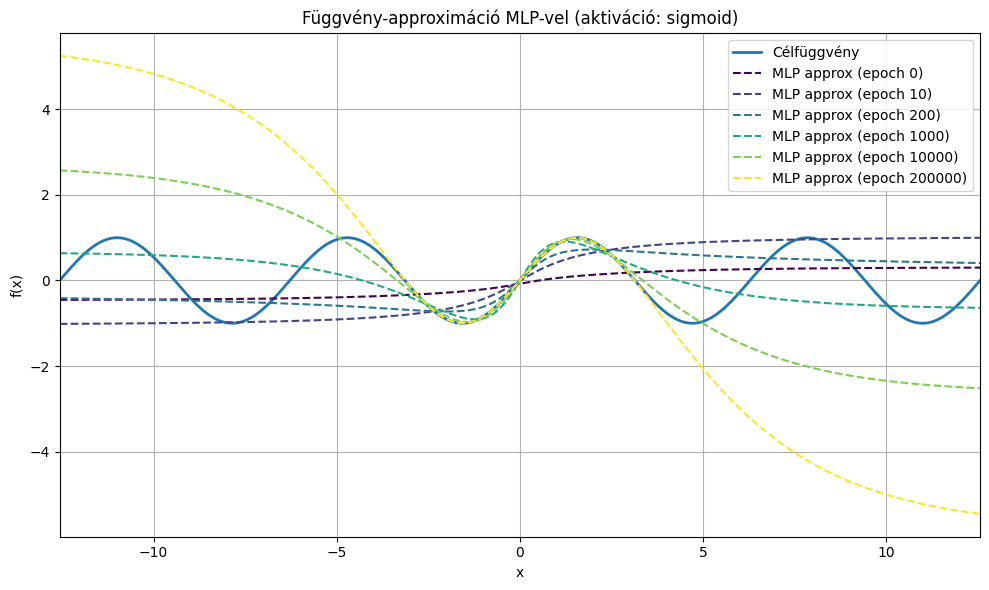

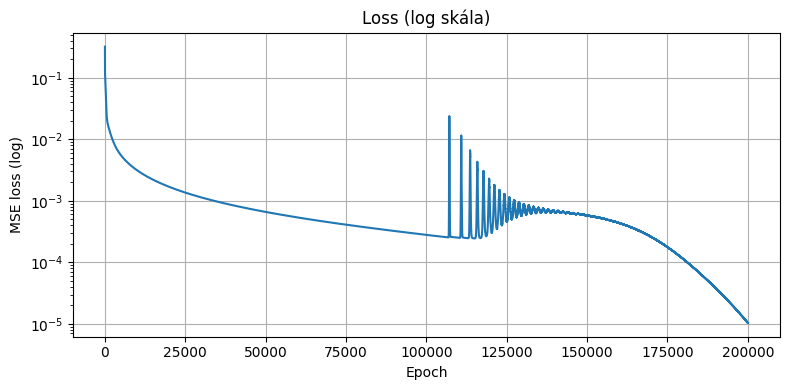

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Beállítások =====

# Választható: "none", "relu", "sigmoid", "tanh"
activation_name = "sigmoid"   # próbáld ki: "none" is!

hidden_size = 16           # rejtett neuronok száma
learning_rate = 0.1
epochs = 200001
plot_snapshots = [0, 10, 200, 1000, 10000, 200000]

# >>>>>>> ITT ÁLLÍTOD, HOGY MEDDIG LÁTSZÓDJON AZ X-TENGELY <<<<<<  # <<< ÚJ
x_plot_min = -4 * np.pi   # pl. -4π
x_plot_max =  4 * np.pi   # pl. +4π

# Approximálandó függvény
def target_function(x):
    return np.sin(x)


# ===== Aktivációk és deriváltak =====

def activation(z, name):
    if name == "none":
        return z
    elif name == "relu":
        return np.maximum(0, z)
    elif name == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif name == "tanh":
        return np.tanh(z)
    else:
        raise ValueError(f"Ismeretlen aktiváció: {name}")

def activation_derivative(z, name):
    if name == "none":
        return np.ones_like(z)
    elif name == "relu":
        return (z > 0).astype(float)
    elif name == "sigmoid":
        s = 1 / (1 + np.exp(-z))
        return s * (1 - s)
    elif name == "tanh":
        t = np.tanh(z)
        return 1 - t**2
    else:
        raise ValueError(f"Ismeretlen aktiváció: {name}")


# ===== Adat generálás =====

# Tanító tartomány: CSAK [-π, π] !!!  # <<< FONTOS
x_train = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1)  # (N,1)
y_train = target_function(x_train)                        # (N,1)

N = x_train.shape[0]
input_size = 1
output_size = 1

# ===== Paraméterek inicializálása (kis MLP: 1 rejtett réteg) =====

rng = np.random.default_rng(0)

W1 = rng.normal(0, 1.0/np.sqrt(input_size), size=(input_size, hidden_size))  # (1, H)
b1 = np.zeros((1, hidden_size))                                             # (1, H)

W2 = rng.normal(0, 1.0/np.sqrt(hidden_size), size=(hidden_size, output_size))  # (H, 1)
b2 = np.zeros((1, output_size))                                               # (1, 1)

# Súly/bias történet vizualizációhoz
W1_history = []
b1_history = []
W2_history = []
b2_history = []

loss_history = []
# snapshots = {}  # már nem kell y_pred-et tárolni, a súlyokat használjuk  # <<< VÁLTOZÁS


# ===== Helper: forward tetszőleges súlyokkal =====  # <<< ÚJ

def forward_with_params(x, W1p, b1p, W2p, b2p):
    """
    Egy forward lépés tetszőleges paraméterekkel.
    x: (N,1)
    """
    z1 = x @ W1p + b1p          # (N,H)
    a1 = activation(z1, activation_name)
    z2 = a1 @ W2p + b2p         # (N,1)
    return z2                   # kimenet (N,1)


# ===== Tanítás (gradient descent backprop-al) =====

for epoch in range(epochs):
    # ---- Forward pass ----
    z1 = x_train @ W1 + b1       # (N, H)
    a1 = activation(z1, activation_name)  # (N, H)

    z2 = a1 @ W2 + b2            # (N, 1)
    y_pred = z2                  # (N, 1)

    # ---- Loss (MSE) ----
    loss = np.mean((y_pred - y_train)**2)
    loss_history.append(loss)

    # Súly/bias mentés MINDEN epochnál
    W1_history.append(W1.copy())
    b1_history.append(b1.copy())
    W2_history.append(W2.copy())
    b2_history.append(b2.copy())

    # ---- Backpropagation ----
    dL_dy = 2 * (y_pred - y_train) / N      # (N,1)

    dL_dW2 = a1.T @ dL_dy                   # (H,1)
    dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)  # (1,1)

    dL_da1 = dL_dy @ W2.T                   # (N,H)
    dL_dz1 = dL_da1 * activation_derivative(z1, activation_name)  # (N,H)

    dL_dW1 = x_train.T @ dL_dz1             # (1,H)
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)  # (1,H)

    # ---- Gradient descent lépés ----
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1

    # Időnként kiírunk
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch:4d} | Loss = {loss:.6f}")

print("Tanítás kész.")


# ===== Vizualizáció 1: függvény vs. háló közelítése különböző epochoknál =====

# Itt már NEM az x_train-t használjuk, hanem egy nagyobb tartományt  # <<< ÚJ
x_plot = np.linspace(x_plot_min, x_plot_max, 800).reshape(-1, 1)
y_plot_true = target_function(x_plot)

plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_plot_true, label="Célfüggvény", linewidth=2)

cmap = plt.cm.viridis

for i, epoch in enumerate(sorted(plot_snapshots)):
    if epoch >= len(W1_history):
        continue  # biztonság kedvéért

    # az adott epoch súlyai
    W1e = W1_history[epoch]
    b1e = b1_history[epoch]
    W2e = W2_history[epoch]
    b2e = b2_history[epoch]

    y_plot_pred = forward_with_params(x_plot, W1e, b1e, W2e, b2e)

    color = cmap(i / max(1, len(plot_snapshots)-1))
    plt.plot(x_plot, y_plot_pred, linestyle="--",
             color=color, label=f"MLP approx (epoch {epoch})")

plt.title(f"Függvény-approximáció MLP-vel (aktiváció: {activation_name})")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.xlim(x_plot_min, x_plot_max)   # <<< X-tengely limit
plt.tight_layout()
plt.show()


# ===== Vizualizáció 2: Loss alakulása =====

epochs_arr = np.arange(len(loss_history))

plt.figure(figsize=(8, 4))

loss_for_plot = np.maximum(loss_history, 1e-10)
plt.semilogy(epochs_arr, loss_for_plot)
plt.title("Loss (log skála)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (log)")
plt.grid(True)

plt.tight_layout()
plt.show()
